In [1]:
# imports
from aerofoil2 import main_pontoon_calc
from aerofoil import calc_naca_area
from mech_module import *
from power_calcs import *


In [3]:
# define river speed and power requirements (the RPM is calculated from the river velocity)
river_vel = 1
turbine_width = 1
turbine_diameter = 1.1
pontoon_length = 1.8
foil_width = pontoon_length/4
r_drum = 0.425/2

print('blade area: ', str(turbine_width*(turbine_diameter/2 - r_drum)))

# define debris defence
block_t = 0.005
block_w = 0.022
block_spacing = 0.2
grid_offset = 0.3


blade area:  0.3375


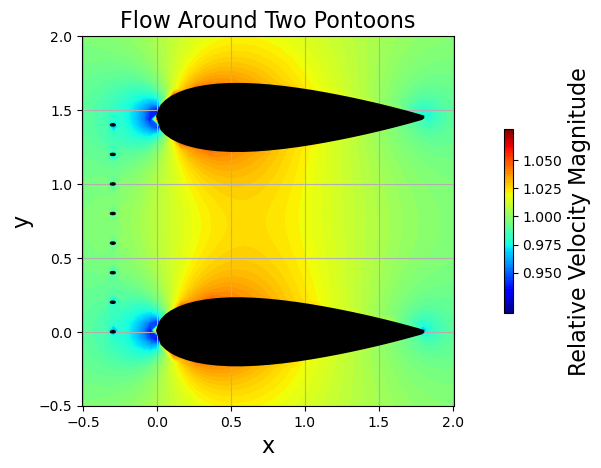

Average river velocity: 1.03 m/s


In [3]:
# apply effect of pontoons on river speed (calculate pontoon volume)
mean_pontoon_velocity = main_pontoon_calc(foil_width, turbine_width, pontoon_length,river_vel,grid=True, block_t = block_t, block_w=block_w, grid_offset=grid_offset, block_round=True, block_spacing=block_spacing, plot=True)
river_vel = mean_pontoon_velocity
print("Average river velocity: %.2f m/s" %river_vel)

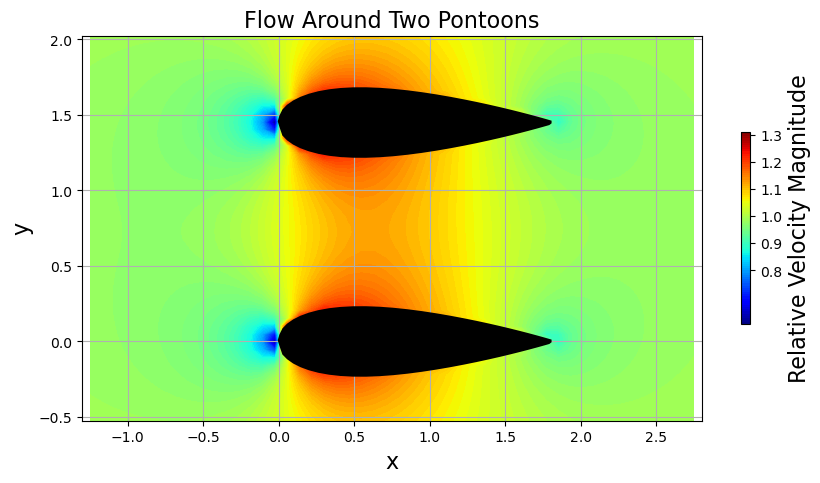

Average river velocity: 1.14 m/s


In [3]:
# apply effect of pontoons on river speed (calculate pontoon volume)
mean_pontoon_velocity = main_pontoon_calc(foil_width, turbine_width, pontoon_length,river_vel,grid=False, block_t = block_t, block_w=block_w, grid_offset=grid_offset, block_round=True, block_spacing=block_spacing, plot=True)
river_vel = mean_pontoon_velocity
print("Average river velocity: %.2f m/s" %river_vel)

In [ ]:
# compare the effect of pontoon thickness and width on river speed
lengths = np.linspace(0.5, 2.5, 5)
widths = np.linspace(0.1, 0.6, 5)
river_vels = []
for l in lengths:
    for w in widths:
        river_vels.append(main_pontoon_calc(w, turbine_width, l, river_vel,grid=False, block_t = block_t, block_w=block_w, grid_offset=grid_offset, block_spacing=block_spacing, plot=False))

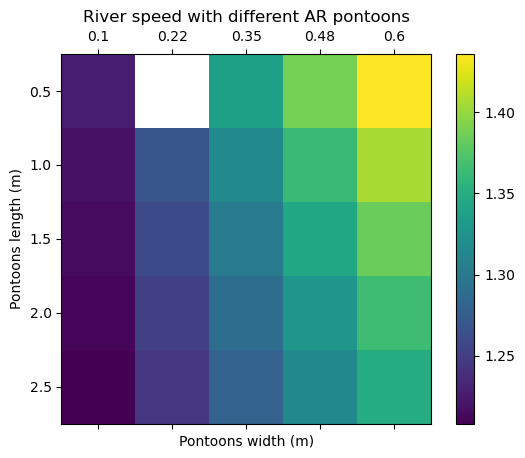

In [ ]:
# plot results as a heatmap with 20 colours
river_vels_plot = np.array(river_vels).reshape(5,5)
fig, ax = plt.subplots()
cax = ax.matshow(river_vels_plot, cmap='viridis')
fig.colorbar(cax)
ax.set_xticklabels(['']+list(np.round(widths,2)))
ax.set_yticklabels(['']+list(np.round(lengths,2)))
ax.set_xlabel('Pontoons width (m)')
ax.set_ylabel('Pontoons length (m)')
ax.set_title('River speed with different AR pontoons')
plt.show()

In [16]:
# Prototype calculations - ignore
pontoon_area = calc_naca_area(foil_width,pontoon_length)
mass = 120

pontoon_volume = mass / 1000
depth = pontoon_volume / pontoon_area

print('Minimum pontoon depth: %.2f m' %depth)



Minimum pontoon depth: 0.22 m


In [13]:
# calculate the area of the turbine
pontoon_area = calc_naca_area(foil_width, pontoon_length)

In [6]:
# calculate the drag force on the pontoon
worst_case = 4
front_area = (pontoon_height * pontoon_width * 2) + (turbine_width * turbine_diameter/2 )
pontoon_drag = 0.5 * 1000 * worst_case**2 * 1.28 * front_area
print('Pontoons drag = ', pontoon_drag, 'N')

NameError: name 'pontoon_height' is not defined

In [7]:
print('Pontoon area: ', pontoon_area)
print('Mean pontoon velocity: ', mean_pontoon_velocity)

Pontoon area:  0.5544025350846892
Mean pontoon velocity:  1.1374458856444594


In [26]:
# how tall do the pontoons need to be to support the turbine?
turbine_mass = 100
pontoon_height = pontoon_height_calc(pontoon_area, turbine_mass)
print('Pontoon height: ', pontoon_height)

Pontoon height:  0.09018717779196685


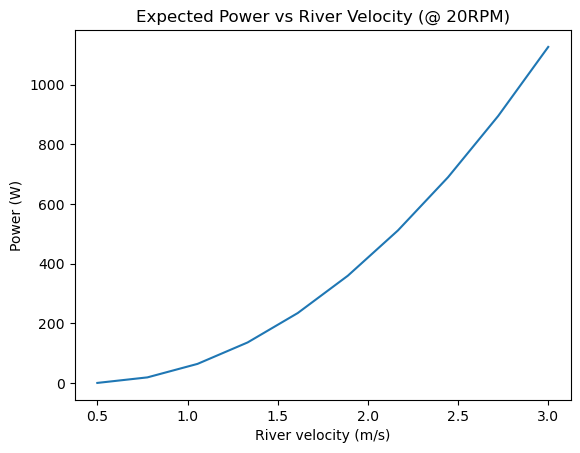

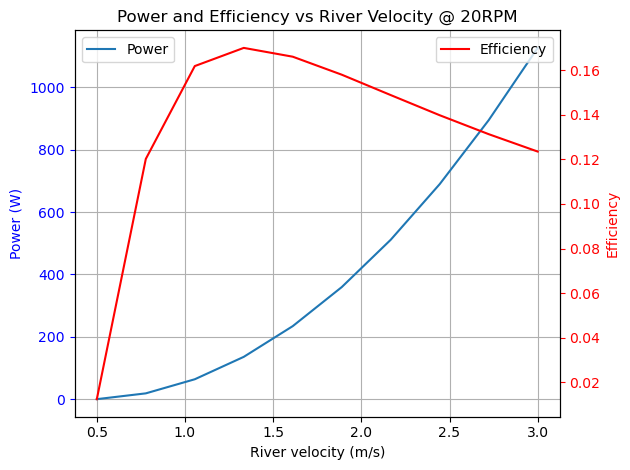

In [5]:
# calculate RPM (using the velocity model for shaft power output)
v = np.linspace(0.5,3,10)
p_array = power(v, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=20)

max_power_array = []
# compare to the power of that flow to get the efficiency
blade_area = ((turbine_diameter/2) - r_drum) * turbine_width
for i in range(len(v)):
    p, _,_,_,_ = power_calc(efficiency=1,V=v[i],A=blade_area)
    max_power_array.append(p)

# overall efficiency
eff = p_array/max_power_array
efficiency = max(eff)

# plot power vs velocity 
plt.plot(v,p_array)
plt.xlabel('River velocity (m/s)')
plt.ylabel('Power (W)')
plt.title('Expected Power vs River Velocity (@ 20RPM)')
plt.show()


# plot power vs velocity and efficiency vs velocity on the same plot
fig, ax1 = plt.subplots()
ax1.plot(v,p_array, label='Power')
ax1.set_xlabel('River velocity (m/s)')
plt.grid()
ax1.set_ylabel('Power (W)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('Power and Efficiency vs River Velocity @ 20RPM')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(v,eff, label='Efficiency', color='r')
ax2.set_ylabel('Efficiency', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')



fig.tight_layout()
plt.show()





In [29]:
# with the RPM, power requirements, river velocity, and efficiency estimates for components
# calculate base dimensions for the turbine (width and radius of the turbine) (calculate rough volume of the turbine)

# set RPM to the max power RPM
RPM = 20

# estimate the efficiency of the turbine
generator_eff = 0.9
gearbox_eff = 0.95
drive_efficiency = generator_eff * gearbox_eff
print('Drive efficiency: ', drive_efficiency)

# hydro efficiency is calculated above as 0.12

# power required = 400w
power_required = 300
efficiency = efficiency * drive_efficiency
print('Overall Efficiency: ', efficiency)

# calculate the area required for the turbine
_, _, _, area, _ = power_calc(efficiency=efficiency,V=1.5,P=power_required)
print('Area required (m^2): ', area)


Drive efficiency:  0.855
Overall Efficiency:  0.1243537041355198
Area required (m^2):  0.7148069251883192


In [30]:
# using the above calculate the required blade thickness (with additional input of material properties)
# define the material properties
sigma_y = 23.5e6
worst_case_vel = 4
sf = 1.5
thickness = minimum_blade_thickness(sigma_y, worst_case_vel*sf, turbine_width/2, r_drum, rho=1000, RPM=RPM,CD = 1.28)
print('Blade thickness (mm): ', thickness)

Blade thickness (mm):  10.249212937688878


In [31]:
# run the debris impact model to determine worst case debris size and impact force
# define the material properties
impact_toughness = 2.6 # J/cm^2
size = debris_calc(impact_toughness, thickness, worst_case_vel)
print('Debris length size (mm): ', size)


Debris length size (mm):  440.15396065564016


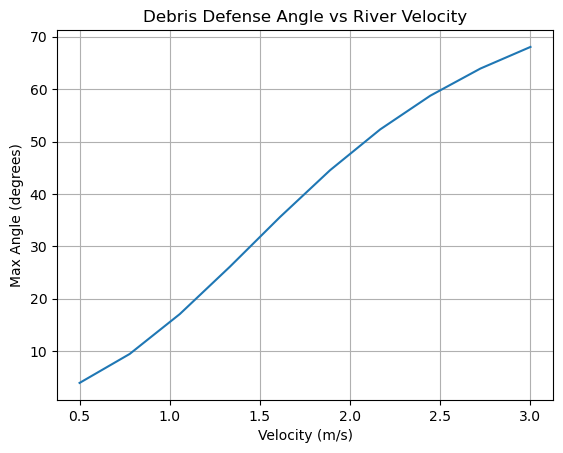

In [32]:
# calculate the angle of the debris defense system to send debris under the turbine
angles = []
velocities = np.linspace(0.5, 3,10 )
for u in velocities:
    angles.append(-debris_angle(u, size/1000 ))

# plot the angle vs velocity
plt.plot(velocities, angles)
plt.grid()
plt.xlabel('Velocity (m/s)')
plt.ylabel('Max Angle (degrees)')
plt.title('Debris Defense Angle vs River Velocity')
plt.show()


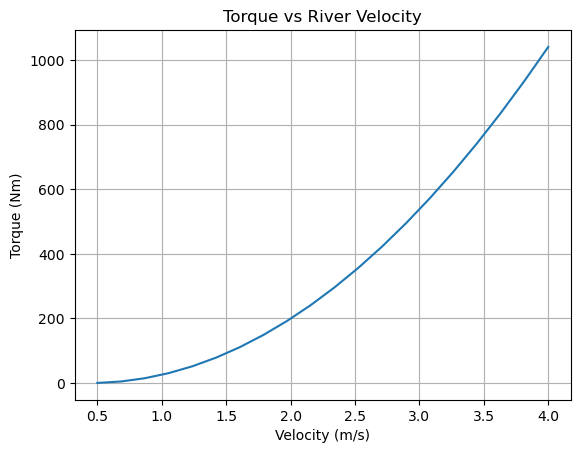

NameError: name 'torque_val' is not defined

In [9]:
# using dimensions and inputs calculate the torque on the drive shaft

# calculate the torque on the drive shaft
vs = np.linspace(0.5,4,20)
torques = []
for v in vs:
    torques.append(torque(v,turbine_diameter,r_drum, turbine_width/2,20))

# plot the torque vs velocity
plt.plot(vs, torques)
plt.grid()
plt.xlabel('Velocity (m/s)')
plt.ylabel('Torque (Nm)')
plt.title('Torque vs River Velocity')
plt.show()

print('Worst case torque (Nm): ', torque_val)

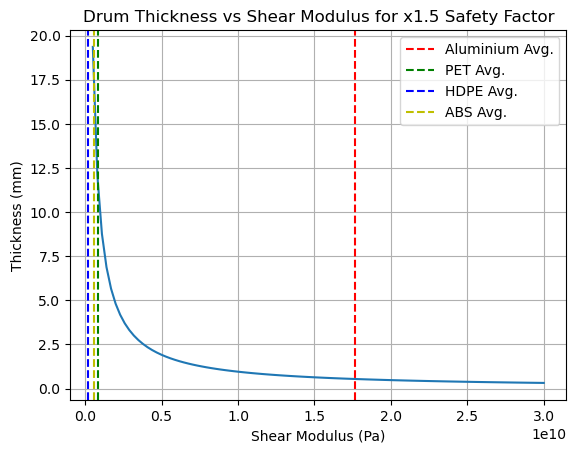

In [36]:
# drum calculations
thickness, shear_strength_mpa, yield_strength_mpa, shear_mod, cost = drum_calc(G=26.5e9, w=3229, l_blade=0.6, l_drum = 1.2, R=200e-3, rho_mat = 2910, cpkg = 3.04)

# plot G vs thickness
Gs = np.linspace(0.5e9, 30e9, 100)
thicknesses = []
for g in Gs:
    val,_,_,_,_ = drum_calc(G=g, w=3229, l_blade=0.6, l_drum = 1.2, R=200e-3, rho_mat = 2910, cpkg = 3.04)
    thicknesses.append(val)

plt.plot(Gs,thicknesses)
plt.xlabel('Shear Modulus (Pa)')
plt.ylabel('Thickness (mm)')
plt.grid()
# plot vertical line at G = 26.5GPa for Aluminium
plt.axvline(x=26.5e9/1.5, color='r', linestyle='--', label='Aluminium Avg.')
plt.axvline(x=1.242e9/1.5, color='g', linestyle='--', label='PET Avg.')
plt.axvline(x=0.266e9/1.5, color='b', linestyle='--', label='HDPE Avg.')
plt.axvline(x=0.8635e9/1.5, color='y', linestyle='--', label='ABS Avg.')
plt.legend()
plt.title('Drum Thickness vs Shear Modulus for x1.5 Safety Factor')
plt.show()



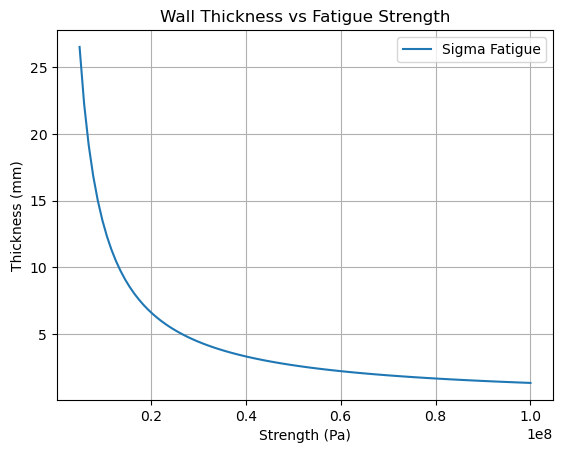

In [6]:
# wall thickness calculation
t_req, yield_strength_mpa, shear_strength_mpa, cost_wall = wall_calc(worst_case_v = 3.5, l_wall = 425e-3, h = 165e-3, sigma_fat = 27.25e6, tau_mod = 0.8505e9, rho_mat = 1200, cpkg = 2.865)

# plot sigma fatigue and sheer modulus vs thickness
sigmas = np.linspace(5e6, 100e6, 100)
thicknesses1 = []
for s in sigmas:
    val,_,_,_ = wall_calc(worst_case_v = 3.5,  sigma_fat =s, tau_mod=np.nan)
    thicknesses1.append(val* 1000)


plt.plot(sigmas, thicknesses1 , label='Sigma Fatigue')
plt.xlabel('Strength (Pa)')
plt.ylabel('Thickness (mm)')
plt.grid()
plt.legend()
plt.title('Wall Thickness vs Fatigue Strength')
plt.show()


Text(0.5, 1.0, 'Wall Thickness vs Shear Modulus')

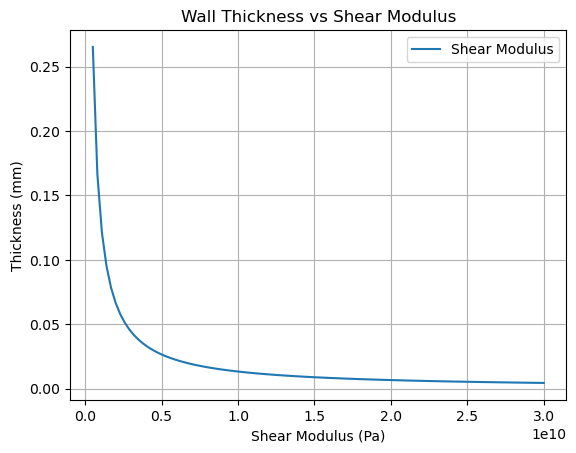

In [5]:

tau_mods = np.linspace(0.e9, 30e9, 100)
thicknesses2 = []

for t in tau_mods:
    val,_,_,_ = wall_calc(worst_case_v = 3.5,tau_mod = t, sigma_fat=t)
    thicknesses2.append(val * 1000)

plt.plot(tau_mods, thicknesses2, label='Shear Modulus')
plt.xlabel('Shear Modulus (Pa)')
plt.ylabel('Thickness (mm)')
plt.grid()
plt.legend()
plt.title('Wall Thickness vs Shear Modulus')
